# Guía de clasificación bancaria — Churn de clientes

Este notebook guía permite analizar un conjunto de datos de clientes bancarios con el objetivo de predecir si un cliente abandona la entidad (`churn`: 1=abandona, 0=no).

El flujo contempla exploración y limpieza, selección automática de variables relevantes usando tests estadísticos, optimización de hiperparámetros usando GridSearchCV CON validación cruzada segura para datasets pequeños, y el ajuste y comparación de modelos árbol de decisión, SVM y random forest.

Las métricas empleadas serán accuracy, precision y recall.

In [2]:
# --- Carga de datos, librerías principales y preprocesamiento categórico ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ejemplo (reemplaza por tu archivo real, aquí es solo una mini-muestra):
df = pd.read_csv('churn_train_val.csv', index_col=False)


# Ajuste tipo categórico (importante para dummies correctos)
df['country'] = df['country'].astype('category')
df['gender'] = df['gender'].astype('category')
df = pd.get_dummies(df, columns=['country','gender'], drop_first=True)
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,781,35,1,0.00,2,0,0,42117.90,0,False,True,True
1,701,21,9,0.00,2,1,1,26327.42,0,False,True,False
2,685,25,10,128509.63,1,1,0,121562.33,0,False,True,False
3,680,34,3,143292.95,1,1,0,66526.01,0,False,False,True
4,756,34,2,148200.72,1,0,0,194584.48,0,True,False,False


## 1. Exploración y visualización inicial

In [3]:
# Inspección básica
df.info()
df.describe()
print('\nDistribución de la variable objetivo:')
print(df['churn'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9000 non-null   int64  
 1   age               9000 non-null   int64  
 2   tenure            9000 non-null   int64  
 3   balance           9000 non-null   float64
 4   products_number   9000 non-null   int64  
 5   credit_card       9000 non-null   int64  
 6   active_member     9000 non-null   int64  
 7   estimated_salary  9000 non-null   float64
 8   churn             9000 non-null   int64  
 9   country_Germany   9000 non-null   bool   
 10  country_Spain     9000 non-null   bool   
 11  gender_Male       9000 non-null   bool   
dtypes: bool(3), float64(2), int64(7)
memory usage: 659.3 KB

Distribución de la variable objetivo:
churn
0    7167
1    1833
Name: count, dtype: int64


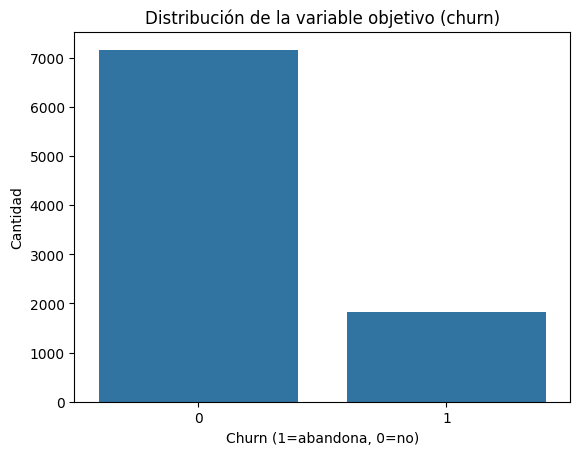

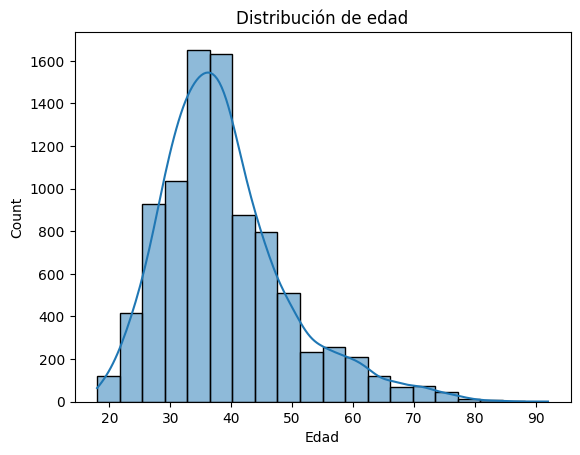

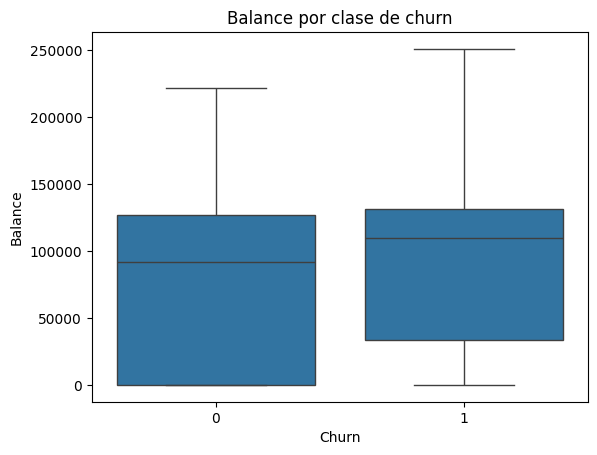

In [4]:
# Visualizaciones principales
sns.countplot(x='churn', data=df)
plt.title('Distribución de la variable objetivo (churn)')
plt.xlabel('Churn (1=abandona, 0=no)')
plt.ylabel('Cantidad')
plt.show()

sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribución de edad')
plt.xlabel('Edad')
plt.show()

sns.boxplot(x='churn', y='balance', data=df)
plt.title('Balance por clase de churn')
plt.xlabel('Churn')
plt.ylabel('Balance')
plt.show()

## 2. Selección automática de variables relevantes según tests estadísticos
Debido al tamaño del dataset, el umbral de p-value es flexible y el algoritmo es robusto para evitar quedarse sin variables.

In [5]:
# Selección automática robusta de variables
from scipy.stats import ks_2samp, chi2_contingency

num_vars = ['credit_score','age','tenure','balance','products_number','estimated_salary']
cat_vars = [col for col in df.columns if col.startswith('country_') or col.startswith('gender_') or col in ['products_number','credit_card','active_member']]

umbral_p = 0.4  # Flexibilidad para datasets pequeños
num_sel = []
for col in num_vars:
    class0 = df[df['churn']==0][col]
    class1 = df[df['churn']==1][col]
    ks_stat, ks_p = ks_2samp(class0, class1)
    if ks_p < umbral_p:
        num_sel.append(col)

cat_sel = []
for col in cat_vars:
    table = pd.crosstab(df[col], df['churn'])
    try:
        _, chi2_p, _, _ = chi2_contingency(table)
        if chi2_p < umbral_p:
            cat_sel.append(col)
    except:
        pass # Para categorías con una sola clase puede fallar

vars_final = list(set(num_sel + cat_sel))

if len(vars_final) == 0:
    print(f"Ninguna variable supera p < {umbral_p}. Usando todas las numéricas y dummies de país/género como fallback.")
    vars_final = num_vars + [col for col in df.columns if col.startswith('country_') or col.startswith('gender_')]
else:
    print(f"Variables seleccionadas (p < {umbral_p}):", vars_final)

X = df[vars_final]
y = df['churn']

Variables seleccionadas (p < 0.4): ['estimated_salary', 'products_number', 'balance', 'country_Germany', 'active_member', 'credit_score', 'country_Spain', 'age', 'gender_Male']


## 3. División entrenamiento/prueba y escalado

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. GridSearchCV con validación cruzada segura para datasets pequeños

In [7]:
# GridSearchCV seguro: n_splits limitado por tamaño de la clase minoritaria
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

min_class_size = y_train.value_counts().min()
n_splits = min(5, min_class_size)
if n_splits < 2:
    n_splits = 2  # Asegura al menos 2 splits
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Árbol de decisión
params_tree = {
    "max_depth": [2, 4, 6, 8, 12, None],
    "min_samples_split": [2, 5, 10]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params_tree, cv=cv, scoring='accuracy')
grid_tree.fit(X_train_scaled, y_train)
best_tree = grid_tree.best_estimator_
print("Mejor Árbol: ", grid_tree.best_params_)

# SVM
params_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf", "linear"]
}
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid=params_svm, cv=cv, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)
best_svm = grid_svm.best_estimator_
print("Mejor SVM: ", grid_svm.best_params_)

# Random Forest
params_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 8, 12, None],
    "min_samples_split": [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params_rf, cv=cv, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
print("Mejor Random Forest: ", grid_rf.best_params_)

Mejor Árbol:  {'max_depth': 6, 'min_samples_split': 10}
Mejor SVM:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor Random Forest:  {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}


In [8]:
# Predicciones con mejores modelos
pred_tree = best_tree.predict(X_test_scaled)
pred_svm  = best_svm.predict(X_test_scaled)
pred_rf   = best_rf.predict(X_test_scaled)

## 5. Comparación de accuracy, precision y recall

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    print(f"{name:15}  Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}")

print_metrics('Árbol decisión', y_test, pred_tree)
print_metrics('SVM', y_test, pred_svm)
print_metrics('Random Forest', y_test, pred_rf)

Árbol decisión   Accuracy: 0.861  Precision: 0.825  Recall: 0.404
SVM              Accuracy: 0.858  Precision: 0.762  Recall: 0.442
Random Forest    Accuracy: 0.870  Precision: 0.831  Recall: 0.455


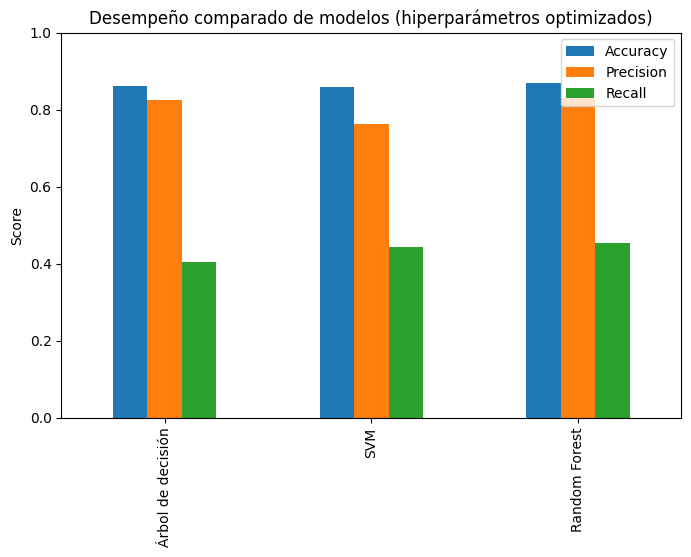

In [10]:
# Gráfico comparativo de desempeño
metrics = ['Accuracy','Precision','Recall']
model_names = ['Árbol de decisión', 'SVM', 'Random Forest']
results = []
for preds in [pred_tree, pred_svm, pred_rf]:
    results.append([
        accuracy_score(y_test, preds),
        precision_score(y_test, preds, zero_division=0),
        recall_score(y_test, preds, zero_division=0)
    ])
result_df = pd.DataFrame(results, columns=metrics, index=model_names)
result_df.plot(kind='bar', ylim=(0,1), figsize=(8,5))
plt.title('Desempeño comparado de modelos (hiperparámetros optimizados)')
plt.ylabel('Score')
plt.show()

## 6. Reflexión y ejercicios

1. Analice los valores de accuracy, precision y recall obtenidos: ¿cuál modelo sería preferible para el negocio?
2. Modifique manualmente los hiperparámetros y observe el efecto sobre los resultados obtenidos con GridSearchCV.
3. Cambie el umbral del p-value en la selección automática de variables y observe cómo cambia el desempeño.
4. Investigue la importancia de variables en al menos uno de los modelos y discuta posibles acciones sobre la base de resultados.
5. Experimente con otros modelos y visualizaciones adicionales para fortalecer el proceso de interpretación y toma de decisiones.
6. Utilice el segundo conjuntod de datos de churn y revise las métricas obtenidas finales para cada modelo. ¿Cómo variaron? ¿Qué implicaciones tiene esto?